# Modeling retinal response variability

Attempt to use simple models to show how the retina transforms a visual input into the variable responses of retinal ganglion cells.

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import h5py
from scipy.stats import zscore, norm
from scipy.ndimage.filters import convolve
from pyret.spiketools import binspikes
from pyret.filtertools import getsta, decompose
# from deepretina.toolbox import load_model, load_partial_model, rolling_window
# from deepretina.io import despine
# from deepretina.metrics import cc

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Will package this up... aesthetics

In [2]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

# Retina schematic  
Highlighting retinal ganglion cells, the output cells of the retina.

![title](img/ganglion_cell_cartoon.png)

# Modeling retinal responses with linear-nonlinear model

## Load retinal responses to a spatiotemporal white noise stimuli

In [3]:
with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/whitenoise.h5', 'r') as h:
    whitenoise_stimulus = np.array(h['test/stimulus'])
    whitenoise_response = np.stack([np.array(h['test/repeats/%s' %key]) for key in sorted(h['test/repeats'].keys())])
    whitenoise_psth = np.array(h['test/response/firing_rate_10ms'])
    time = np.array(h['test/time'])
    sample_rate = 100.

In [4]:
whitenoise_stimulus.shape

(30011, 50, 50)

In [5]:
print('Each repeat is %0.1f minutes long, at a %0.1f Hz sampling rate.' %(whitenoise_stimulus.shape[0]/(sample_rate*60.), sample_rate))

Each repeat is 5.0 minutes long, at a 100.0 Hz sampling rate.


In [6]:
print(whitenoise_response.shape)
print('There are %d cells and %d repeats.' %(whitenoise_response.shape[:2]))

(28, 2, 30011)
There are 28 cells and 2 repeats.


## Visualize the data

#### First repeat of white noise

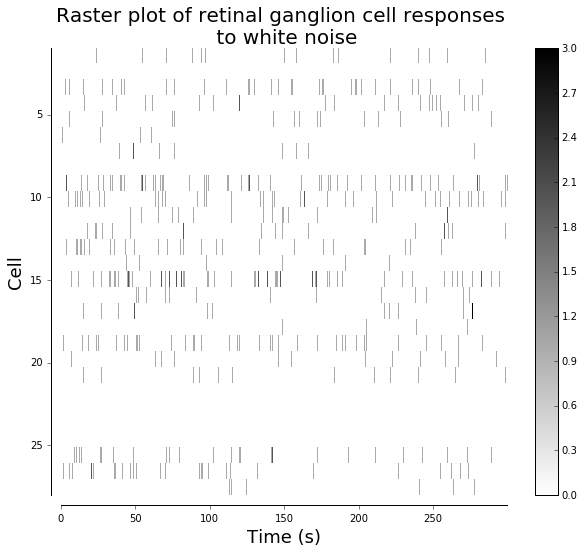

In [7]:
plt.imshow(whitenoise_response[:,0,:], aspect='auto', cmap='gray_r', extent=(time[0], time[-1], whitenoise_response.shape[0], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Cell', fontsize=18)
plt.title('Raster plot of retinal ganglion cell responses \n to white noise', fontsize=20)
plt.colorbar()
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

Which cell has the most number of spikes?

In [8]:
most_spiking_cell = np.argmax(np.sum(whitenoise_response[:,0,:], axis=1))
most_spikes = np.sum(whitenoise_response[:,0,:], axis=1)[most_spiking_cell]
print('Cell %d has the highest firing rate at %0.2f Hz' %(most_spiking_cell, 
                                                          most_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))
mean_spikes = np.mean(np.sum(whitenoise_response[:,0,:], axis=1))
print('Mean spike rate is %0.2f Hz' %(mean_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))

Cell 14 has the highest firing rate at 13.87 Hz
Mean spike rate is 3.67 Hz


Let's analyze what cell 14 is doing.

## Linear input-output relationship of a cell

In [9]:
spike_times = [time[t] for t,r in enumerate(whitenoise_response[most_spiking_cell,0]) if r>0]

In [10]:
# getsta takes (time, stimulus, spikes, filter_length in frames)
filter_length = 40 # at 100 Hz, 40 frames is 0.4 seconds (400 milliseconds)
zscored_stimulus = zscore(whitenoise_stimulus)
average_feature, tax = getsta(time, zscored_stimulus, spike_times, filter_length=filter_length)
average_feature.shape

(40, 50, 50)

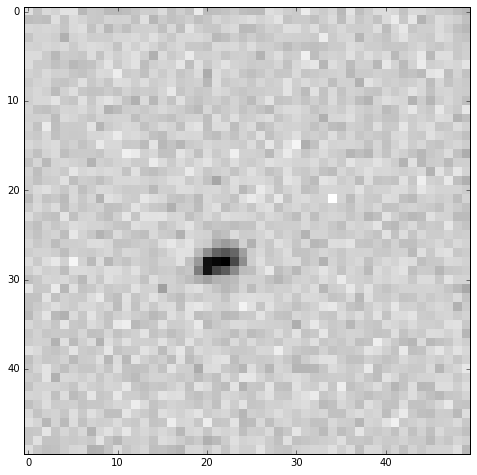

In [11]:
plt.imshow(average_feature[35])

## Decompose this 3d average feature conveyed by the cell into it's representative spatial and temporal components

In [12]:
spatial_feature, temporal_feature = decompose(average_feature)

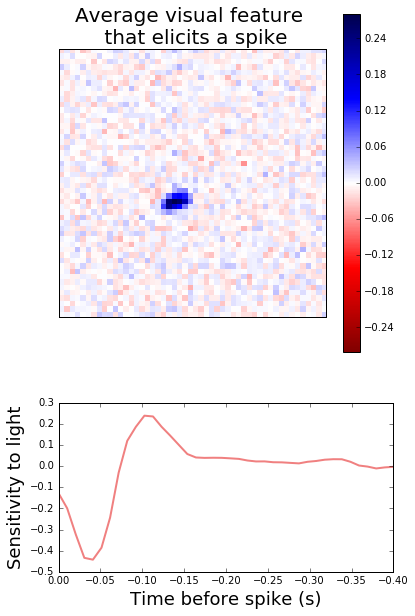

In [13]:
# plot STA
fig = plt.figure(figsize=(6,10))
filter_time = np.linspace(0.0, filter_length/sample_rate, filter_length)

# build the figure
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# plot spatial profile
ax = fig.add_subplot(gs[0])
spatial_feature -= np.mean(spatial_feature)
maxval = np.max(np.abs(spatial_feature))
img = ax.imshow(spatial_feature, cmap='seismic_r', interpolation='nearest',
        aspect='equal', vmin=-maxval, vmax=maxval)
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(img)
plt.title('Average visual feature \n that elicits a spike', fontsize=20)

# plot temporal profile
ax = fig.add_subplot(gs[1])
ax.plot(-filter_time, temporal_feature[::-1], linestyle='-', linewidth=2, color='LightCoral')
ax.set_xlim(filter_time[0], -filter_time[-1])
plt.xlabel('Time before spike (s)', fontsize=18)
plt.ylabel('Sensitivity to light', fontsize=18)

# How linear is this cell?  
# Can we plot the actual vs predicted firing rates?

Find the nonlinearity of this cell.

#### Filter the visual stimulus with our average feature to get the predicted linear response of the cell

In [14]:
zscored_stimulus.shape

(30011, 50, 50)

In [ ]:
filtered_stim = convolve(zscored_stimulus[:100], average_feature, mode='constant')

In [ ]:
filtered_stim.shape

## Load retinal dataset with 112 repeats of 30s natural scenes

In [ ]:
with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/naturalscene.h5', 'r') as h:
    stimulus = np.array(np.array(h['test/stimulus']))
    psth = np.array(h['test/response/firing_rate_10ms'])
    repeats = np.stack([np.array(h['test/repeats/%s' %key]) for key in sorted(h['test/repeats'].keys())])
    time = np.array(h['test/time'])

## Visual stimulus

In [224]:
stimulus.shape

(3003, 50, 50)

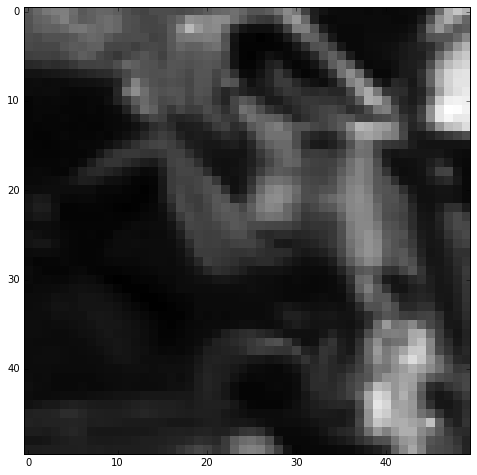

In [227]:
plt.imshow(stimulus[200])

## What does the average output of the retina look like?

In [228]:
psth.shape

(28, 3003)

#### Visualize average responses of all 28 cells for first 5 seconds of each repeat

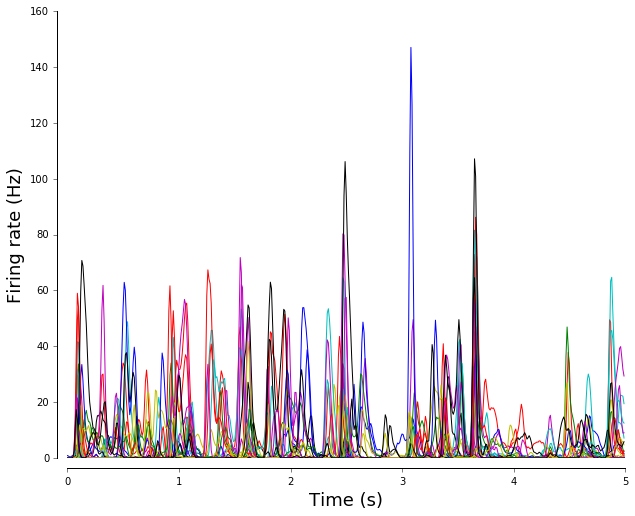

In [229]:
p = plt.plot(time[:500], psth[:,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Qualitatively look at how change of natural scene every 1s relates to retinal firing for example cell

(0, 5)

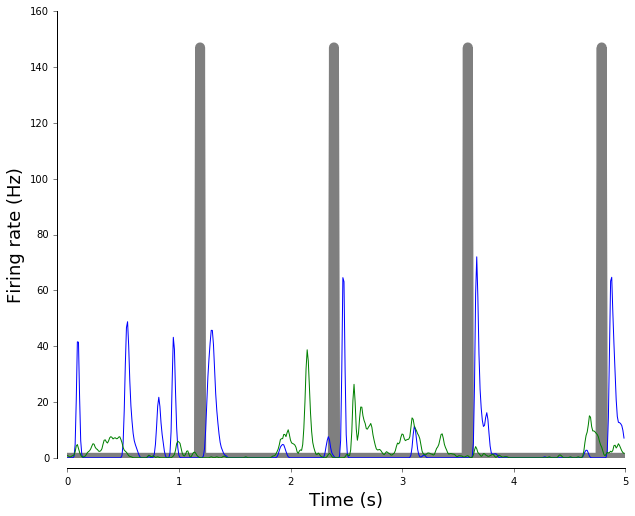

In [230]:
# Plot mean difference between frames
mean_stimulus_difference = abs(np.mean(np.diff(stimulus.astype('float32'), axis=0), axis=(1,2)))
plt.plot(time[:-1], np.max(psth)*np.where(mean_stimulus_difference > 2*np.std(mean_stimulus_difference), 1, 0), 
         'k', linewidth=10, alpha=0.5)

p = plt.plot(time[:500], psth[3,:500].T)
p = plt.plot(time[:500], psth[0,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0,5])

# A simple linear-nonlinear model of retinal responses

In [231]:
with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/whitenoise.h5', 'r') as h:
    whitenoise = np.array(np.array(h['test/stimulus']))
    whitenoise_psth = np.array(h['test/response/firing_rate_10ms'])
    whitenoise_time = np.array(h['test/time'])

## TODO: compute linear receptive field

## TODO: compute actual vs predicted response to get nonlinearity

## TODO: fit sigmoid to actual-predicted plot

## TODO: compute correlation between response and LN predictions

## TODO: show how this doesn't generalize well to predicting natural scene responses

## Characterizing retinal noise

In [232]:
repeats.shape

(28, 112, 3003)

#### Raster of first cell

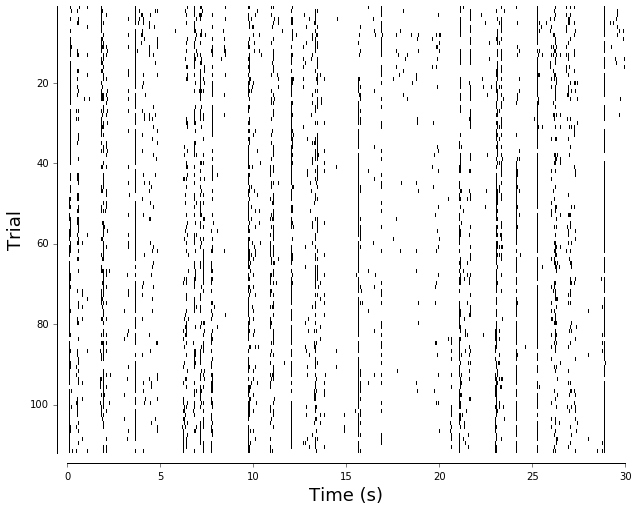

In [237]:
plt.imshow(repeats[20], aspect='auto', clim=[0,1], cmap='gray_r', extent=(time[0], time[-1], repeats.shape[1], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Get coarser bins

In [216]:
# spike_times = np.where(repeats[0], time, 0)
# coarse_bins = np.stack([binspikes(repeats[0,i], binsize=0.1, time=np.linspace(0,time[-1],300)) for i in range(repeats.shape[1])])
# coarse_time = coarse_bins[0,1,:]
# coarse_bins = coarse_bins[:,0,:].squeeze()

In [238]:
var_spike_count = np.var(repeats[0], axis=0)
mean_spike_count = np.mean(repeats[0], axis=0)

In [239]:
np.mean(var_spike_count)

0.020466857759587346

In [240]:
np.mean(mean_spike_count)

0.022129656058227486

In [241]:
cartoon_mean_spike_count = 2.0
cartoon_var_spike_count = 0.8

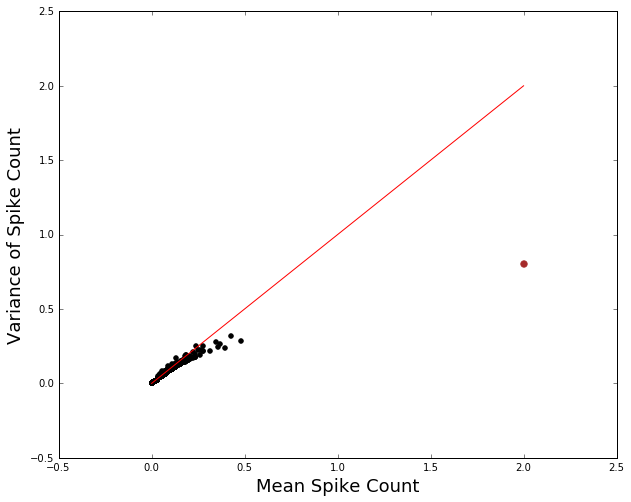

In [242]:
plt.scatter(mean_spike_count, var_spike_count, color='k')
plt.plot(np.linspace(0,2,10), np.linspace(0,2,10), color='r')
plt.scatter(cartoon_mean_spike_count, cartoon_var_spike_count, color='brown', s=40)
plt.xlabel('Mean Spike Count', fontsize=18)
plt.ylabel('Variance of Spike Count', fontsize=18)

## Compute scaling relationship

In [173]:
# nbins = 8
# n, _ = np.histogram(mean_spike_count, bins=nbins)
# sy, _ = np.histogram(mean_spike_count, bins=nbins, weights=var_spike_count)
# sy2, xs = np.histogram(mean_spike_count, bins=nbins, weights=np.array(var_spike_count)**2)
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# plt.errorbar((xs[1:] + xs[:-1])/2, mean, yerr=std, fmt='r-', linewidth=4)